In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import sklearn

import procrustes

import kmapper as km

from scipy import stats

import json

from matplotlib.patches import Polygon

In [2]:
def flatten(regular_list):
    flat_list = [item for sublist in regular_list for item in sublist]
    
    return flat_list

In [3]:
mdata = pd.read_csv('passiflora.csv')
mdata['heteroblasty'] = mdata['ontogeny'] / mdata['total']

# doing procrustes on the whole data set takes a while, so might want to read only first 1000 rows
#mdata = mdata[:1000]

In [4]:
# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':7,
 'amethystina':4,
 'alata':6,
 'rubra':2,
 'misera':1,
 'setacea':3,
 'triloba':5,
 'nitida':6,
 'actinia':5,
 'villosa':6,
 'micropetala':2,
 'mucronata':7,
 'maliformis':7,
 'miersii':5,
 'malacophylla':7,
 'gibertii':3,
 'mollissima':3,
 'caerulea':3,
 'gracilis':4,
 'foetida':4,
 'racemosa':6,
 'tenuifila':3,
 'cristalina':7,
 'ligularis':6,
 'cincinnata':3,
 'coccinea':7,
 'hatschbachii':3,
 'morifolia':4,
 'organensis':2,
 'capsularis':2,
 'edmundoi':3,
 'galbana':7,
 'tricuspis':2,
 'pohlii':2,
 'biflora':2,
 'sidifolia':5,
 'suberosa':3,
 'edulis':6,
 'coriacea':1,
 'kermesina':3}

In [5]:
mdata = mdata.replace(species_classes)

# Procrustes alignment of landmark data

In [6]:
def get_landmarks(df):
    xs = df.filter(regex="^x[0-9]+").to_numpy()
    ys = df.filter(regex="^y[0-9]+").to_numpy()
    lmks = np.stack((xs, ys), axis=2)
    
    centroids = procrustes.get_position(lmks)
    lmks_centered = procrustes.remove_position(lmks)

    scale_factors = procrustes.get_scale(lmks_centered)
    lmks_scaled = procrustes.remove_scale(lmks_centered)

    res_gpa = procrustes.gpa(lmks_scaled)
    lmk_mean = res_gpa['mean']

    lmk_pts = {'original': lmks,
               'centered': lmks_centered,
               'scaled': lmks_scaled,
               'aligned': res_gpa['aligned']
               }
    props = {'centroids': centroids,
             'scale_factors': scale_factors
             }

    return(lmk_pts, lmk_mean, props)

In [7]:
# use this cell instead of the next if doing a mapper for each species

# lmk_pts = {}
# lmk_mean = {}
# props = {}

# for i in range(0, len(species)):
#     lmk_pts[i], lmk_mean[i], props[i] = get_landmarks(mdata[mdata['species'] == i])

In [8]:
lmk_pts, lmk_mean, props = get_landmarks(mdata)

ssq diff 5.684341886080802e-14


# Plot aligned leaf and average shape

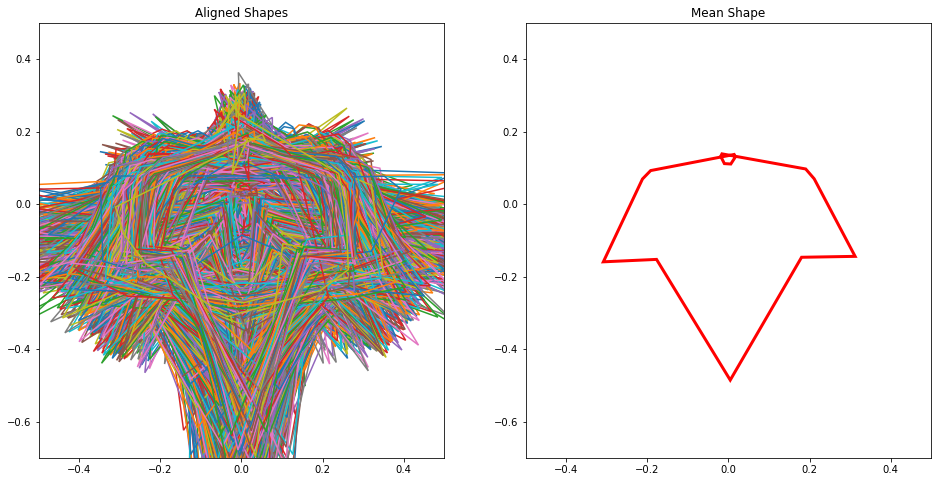

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for ax in axs:
    ax.set_xlim(left=-0.5, right=0.5)
    ax.set_ylim(bottom=-0.7, top=0.5)

for i in range(lmk_pts['scaled'].shape[0]):
    col = colors[i % len(colors)]

    pa_xy = lmk_pts['aligned'][i]
    pa = Polygon(pa_xy, edgecolor=col, facecolor='none', linewidth=1.5)
    axs[0].add_patch(pa)
    axs[0].set_title('Aligned Shapes')
    
    

pm = Polygon(lmk_mean, edgecolor='red', facecolor='none', linewidth=3)
axs[1].add_patch(pm)
axs[1].set_title('Mean Shape')

plt.show()

# Compute leaf distances

### Correlation distance

In [10]:
landmark_matrix = np.array([flatten(list(lmk_pts['aligned'][i])) for i in range(0,len(mdata))])

In [11]:
distance_correlation = squareform(pdist(landmark_matrix, 'correlation'))

# Lenses

### Heteroblasty

In [12]:
heteroblasty_lens = np.array(mdata['heteroblasty'].tolist())

### Vein to blade

In [13]:
# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# landmarks in order to run shoestring algorithm
coords_area = [6, 15, 14, 13, 12, 11, 10, 9, 8, 7, 1]
coords_vein = [6, 15, 5, 13, 4, 11, 3, 9, 2, 7, 1]

In [14]:
leaf_areas = []
leaf_veins = []

# compute blade area
for j in lmk_pts['aligned']:
    x = np.array([j[i-1][0] for i in coords_area])
    y = np.array([j[i-1][1] for i in coords_area])
    leaf_areas.append(PolyArea(x,y))

# compute vein area
for j in lmk_pts['aligned']:
    x = np.array([j[i-1][0] for i in coords_vein])
    y = np.array([j[i-1][1] for i in coords_vein])
    leaf_veins.append(PolyArea(x,y))    

In [15]:
vtb_lens = np.array([i/j for i,j in zip(leaf_veins, leaf_areas)])

# KeplerMapper

In [65]:
mapper = km.KeplerMapper(verbose = 0)

graph = mapper.map(
    heteroblasty_lens,
    distance_correlation,
    cover = km.Cover(n_cubes = 13, perc_overlap = 0.5),
    # remember to change epsilon based on distance matrix
    clusterer = sklearn.cluster.DBSCAN(eps = 0.01, min_samples = 2, metric = 'precomputed'),
    precomputed = 'True')

html = mapper.visualize(
    graph,
    path_html = 'test_mapper.html',
#    color_values = lens,
#    color_function_name = 'test',
#    node_color_function="mode",
#     colorscale = colorscale_discrete7,
    title = 'test')

# Giotto-tda

The covering method might be different--getting slightly different results in terms of heteroblasties represented in each interval

In [36]:
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

In [18]:
# # takes as input the coordinates of a leaf
# def heteroblasty_func(i):
#     x1_value = i[0]
#     heteroblasty_value = mdata[mdata['x1']==x1_value].heteroblasty.values[0]
#     return heteroblasty_value

In [47]:
# takes as input the nth row of the correlation matrix and returns the heteroblasty of the nth leaf
def heteroblasty_func(i):
    index = np.where(i == 0)[0][0]
    heteroblasty_value = mdata.loc[index].heteroblasty
    
    return heteroblasty_value

In [205]:
cover = CubicalCover(n_intervals=13, overlap_frac=0.5)

pipe = make_mapper_pipeline(
    filter_func=heteroblasty_func,
    cover=cover,
    clusterer=sklearn.cluster.DBSCAN(eps = 0.01, min_samples = 2, metric = 'precomputed'),
    verbose=True,
    store_edge_elements=True
)

In [207]:
graph2 = pipe.fit_transform(distance_correlation)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.4s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


In [186]:
node_elements = graph2.vs["node_elements"]

In [232]:
giotto_edges = []

for e in graph2.es:
    giotto_edges.append(list(e.tuple))

# Pie chart mapper

for each node in the mapper, create an average outline

In [245]:
# Giotto

count = 0

for i in node_elements:
    node_data = mdata.loc[list(i)]
    node_lmk_pts, node_lmk_mean, node_props = get_landmarks(node_data)

    fig, ax = plt.subplots(figsize = (8,8))

    ax.set_xlim(left=-0.5, right=0.5)
    ax.set_ylim(bottom=-0.7, top=0.5)

    pm = Polygon(node_lmk_mean, edgecolor='red', facecolor='none', linewidth=3)
    ax.add_patch(pm)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    filename = 'passiflora_pie_graph/giotto/node_avg_outline/'+str(count)+'.png'
    plt.savefig(filename, dpi = 96, pil_kwargs={'optimize':True})
    plt.close(fig)
    
    count +=1

ssq diff 8.881784197001252e-15
ssq diff 0.0
ssq diff 0.0
ssq diff 0.0
ssq diff 2.4868995751603507e-14
ssq diff 2.1316282072803006e-14
ssq diff 7.105427357601002e-15
ssq diff 1.0658141036401503e-14
ssq diff 1.0658141036401503e-14
ssq diff 1.4210854715202004e-14
ssq diff 0.0
ssq diff 1.4210854715202004e-14
ssq diff 2.4868995751603507e-14
ssq diff 3.552713678800501e-15
ssq diff 0.0
ssq diff 2.6645352591003757e-15
ssq diff 8.881784197001252e-16
ssq diff 5.329070518200751e-15
ssq diff 0.0
ssq diff 2.6645352591003757e-15
ssq diff 5.204170427930421e-18
ssq diff 6.071532165918825e-18
ssq diff 1.734723475976807e-18
ssq diff 1.7763568394002505e-15
ssq diff 8.673617379884035e-19
ssq diff 0.0
ssq diff 5.329070518200751e-15
ssq diff 5.329070518200751e-15
ssq diff 0.0
ssq diff 4.2420580936841645e-13
ssq diff 5.329070518200751e-15
ssq diff 2.220446049250313e-15
ssq diff 3.552713678800501e-15
ssq diff 2.6645352591003757e-15
ssq diff 1.7763568394002505e-15
ssq diff 3.469446951953614e-18
ssq diff 5.5511

In [238]:
# Kepler

for i in list(graph['nodes'].keys()):
    node_data = mdata.loc[graph['nodes'][i]]
    node_lmk_pts, node_lmk_mean, node_props = get_landmarks(node_data)

    fig, ax = plt.subplots(figsize = (8,8))

    ax.set_xlim(left=-0.5, right=0.5)
    ax.set_ylim(bottom=-0.7, top=0.5)

    pm = Polygon(node_lmk_mean, edgecolor='red', facecolor='none', linewidth=3)
    ax.add_patch(pm)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    filename = 'passiflora_pie_graph/kepler/node_avg_outline/'+i+'.png'
    plt.savefig(filename, dpi = 96, pil_kwargs={'optimize':True})
    plt.close(fig)

ssq diff 0.0
ssq diff 1.7763568394002505e-15
ssq diff 3.469446951953614e-18
ssq diff 2.220446049250313e-16
ssq diff 1.1813466871402056e-14
ssq diff 0.0
ssq diff 2.3418766925686896e-17
ssq diff 0.0
ssq diff 8.417225250134663e-14
ssq diff 2.0816681711721685e-17
ssq diff 3.469446951953614e-18
ssq diff 9.481304630298837e-14
ssq diff 2.498001805406602e-16
ssq diff 4.163336342344337e-17
ssq diff 8.986908439645447e-14
ssq diff 1.734723475976807e-18
ssq diff 0.0
ssq diff 6.938893903907228e-17
ssq diff 6.938893903907228e-18
ssq diff 1.1102230246251565e-16
ssq diff 8.881784197001252e-15
ssq diff 2.6645352591003757e-15
ssq diff 2.220446049250313e-16
ssq diff 4.85722573273506e-17
ssq diff 1.3877787807814457e-16
ssq diff 3.3306690738754696e-16
ssq diff 5.204170427930421e-18
ssq diff 1.6653345369377348e-16
ssq diff 1.734723475976807e-18
ssq diff 0.0
ssq diff 8.986908439645447e-14
ssq diff 4.7704895589362195e-18
ssq diff 3.469446951953614e-18
ssq diff 5.551115123125783e-17
ssq diff 0.0
ssq diff 3.469

ValueError: The input X must contain atleast 2 landmark sets.

create a json dict to input into the mapper visualization

class number = color number

In [249]:
# Giotto

json_dict_giotto = {"nodes": [], "links": []}

for i in range(0, len(node_elements)):
    testlist = mdata.loc[list(node_elements[i])]['species'].tolist()
    
    n = {
        "id": i, # this is used for links
        "group": int(stats.mode(testlist)[0][0]), # this is the outer node color
        "node_size": len(mdata.loc[list(node_elements[i])]),
        "heteroblasty": np.mean(mdata.loc[list(node_elements[i])]['heteroblasty'].tolist()),
        "pieChart": []
        }
        
    for j in set(testlist):
        n["pieChart"].append({"color":j, "percent":100*testlist.count(j)/len(testlist)})

    json_dict_giotto["nodes"].append(n)

for i in range(0, len(giotto_edges)):
    source = giotto_edges[i][0]
    target = giotto_edges[i][1]
    value = graph2.es['weight'][i]
    json_dict_giotto["links"].append({"source": source, "target": target, "value": value})
        
with open('passiflora_pie_graph/giotto/data.json', 'w') as outfile:
    json.dump(json_dict_giotto, outfile)

In [22]:
# Kepler

json_dict = {"nodes": [], "links": []}

for i in graph['nodes']:
    testlist = mdata.loc[graph['nodes'][i]]['species'].tolist()
    
    n = {
        "id": i, # this is used for links
        "group": int(stats.mode(testlist)[0][0]), # this is the outer node color
        "node_size": len(mdata.loc[graph['nodes'][i]]),
        "heteroblasty": np.mean(mdata.loc[graph['nodes'][i]]['heteroblasty'].tolist()),
        "pieChart": []
        }
        
    for j in set(testlist):
        n["pieChart"].append({"color":j, "percent":100*testlist.count(j)/len(testlist)})

    json_dict["nodes"].append(n)

# we need a double for loop since some link values are length > 1
for k in range(0, len(graph['links'])):
    for l in list(graph['links'].values())[k]:
        source = list(graph['links'].keys())[k]
        target = l
        value = len(set(mdata.loc[graph['nodes'][source]]['plant'].tolist()) & set(mdata.loc[graph['nodes'][target]]['plant'].tolist()))
        json_dict["links"].append({"source": source, "target": target, "value": value})
        
with open('passiflora_pie_graph/kepler/data.json', 'w') as outfile:
    json.dump(json_dict, outfile)